# Handwritten Digit Recognition With Deep Learning
#### A classic image recognition problem.  Exploratory project - [repo here.](https://github.com/jeremyrcouch/digitrecognition)
---
The [MNIST](http://yann.lecun.com/exdb/mnist/) database is a collection of 70,000 handwritten digits (0 to 9).  The goal is to build a model capable of recognizing a digit given only the image information.  Deep learning is well suited to this task, so we're going to build a neural network to classify the digits.

In [1]:
import math
from typing import List

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from keras import layers, backend
from keras.datasets import mnist
from keras.models import Model
from keras.utils import np_utils
from keras.callbacks import Callback, LearningRateScheduler, EarlyStopping

Using TensorFlow backend.


In [52]:
RANDOM_SEED = 17
VAL_SET_RATIO = 0.125

FONTSIZE = 20
LINEWIDTH = 5
MARKERSIZE = 12

In [293]:
np.random.seed(RANDOM_SEED)  # for repeatability
backend.set_image_data_format('channels_first')

In [290]:
def reshape_input_data(data: np.ndarray) -> np.ndarray:
    """Reshape and scale input (image) data for use.
    
    Args:
        data: numpy array, input data
        
    Returns:
        _: numpy array, reshaped and scaled input data
    """
    
    return data.reshape(data.shape[0], 1, data.shape[1], data.shape[2])/255
    
    
def split_val_set_from_train(X_train_in: np.ndarray, y_train_in: np.ndarray,
                             val_ratio: float = 0.125):
    """Split a validation set out of the training set.

    Args:
        X_train_in: numpy array, training set images
        y_train_in: numpy array, training set labels
        val_ratio: float, ratio of training set to use as validation set

    Returns:
        (X_train, y_train), (X_val, y_val): numpy arrays of images and labels
    """
    
    val_size = int(val_ratio*X_train_in.shape[0])
    X_val = X_train_in[-val_size:, ...]
    y_val = y_train_in[-val_size:, ...]
    X_train = X_train_in[:X_train_in.shape[0] - val_size, ...]
    y_train = y_train_in[:y_train_in.shape[0] - val_size, ...]

    return (X_train, y_train), (X_val, y_val)


def visualize_fit(metrics):
    """Visualize fitting process."""
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(9, 9))
    ax1.plot(metrics.acc, 'g', linewidth=LINEWIDTH,
             markersize=MARKERSIZE, label='train')
    ax1.plot(metrics.val_acc, 'b', linewidth=LINEWIDTH,
             markersize=MARKERSIZE, label='val')
    ax1.legend(fontsize=FONTSIZE-4)
    ax1.grid()
    ax1.set_ylabel('Accuracy', fontsize=FONTSIZE)
    ax1.tick_params(labelsize=FONTSIZE-4)
    ax2.plot(metrics.lr, 'r', linewidth=LINEWIDTH,
             markersize=MARKERSIZE)
    ax2.grid()
    ax2.set_xlabel('Epoch', fontsize=FONTSIZE)
    ax2.set_ylabel('Learning Rate', fontsize=FONTSIZE)
    ax2.tick_params(labelsize=FONTSIZE-4)
    fig.tight_layout()


def lr_function(epoch: int) -> float:
    """Learning rate function.
    
    Args:
        epoch: int, epoch number
        
    Returns:
        _: float, learning rate
    """
    
    init = 0.001
    drop = 0.5
    epochs_drop = 5.0
    
    return init * math.pow(drop, math.floor((1 + epoch)/epochs_drop))


class recordMetrics(Callback):
    """Class to record metrics during model training process."""

    def on_train_begin(self, logs={}):
        self.lr = []
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []

    def on_epoch_end(self, batch, logs={}):
        self.lr.append(self.model.optimizer.get_config()['lr'])
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))


def make_mosaic(imgs: np.ndarray, nrows: int, ncols: int, border: int = 1) -> np.ndarray:
    """Given a set of images with all the same shape, makes a mosaic.
    
    Args:
        imgs: array of floats, image data
        nrows: int, number of rows of mosaic
        ncols: int, number of cols of mosaic
        border: int, border pixels
        
    Returns:
        mosaic: masked array, image mosaic
    """

    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]

    mosaic = np.ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                               ncols * imshape[1] + (ncols - 1) * border),
                              dtype=np.float32)

    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols

        mosaic[row*paddedh:row*paddedh + imshape[0],
               col*paddedw:col*paddedw + imshape[1]] = imgs[i]

    return mosaic


def classification_heat_map(y_test: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    """Builds classification heat map.
    
    Args:
        y_test: array of ints, true labels
        y_pred: array of floats, predicted labels
        
    Returns:
        heat: array of ints, true vs predicted counts
    """

    cat_num = len(np.unique(y_test))
    heat = np.zeros((cat_num, cat_num), dtype='int')
    for test, pred in zip(y_test, y_pred):
        heat[test, pred] += 1

    return heat


def plot_heat(zero_heat):
    """Plot heat map."""

    fig = plt.figure(figsize=(9, 9))
    img = plt.imshow(zero_heat, cmap='viridis')
    plt.xlabel('Predicted', fontsize=FONTSIZE)
    plt.ylabel('True', fontsize=FONTSIZE)
    plt.xticks([i for i in range(10)])
    plt.yticks([i for i in range(10)])
    plt.tick_params(axis='both', labelsize=FONTSIZE)
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(img, cax=cax)
    cbar.ax.tick_params(labelsize=FONTSIZE-4)
    cbar.ax.get_xaxis().labelpad = 7
    cbar.ax.set_xlabel('Count', fontsize=FONTSIZE-4)
    cbar.outline.set_visible(False)
    fig.tight_layout()


def plot_weights(weights):
    """Plot weights."""

    fig = plt.figure(figsize=(9, 9))
    img = plt.imshow(weights, cmap='viridis')
    plt.tick_params(axis='both', labelsize=FONTSIZE)
    ax = fig.gca()
    ax.axis('off')
    fig.tight_layout()


def plot_layer_outputs(model, layer, X_test: np.ndarray, test_ind: int):
    """Plot layer outputs.
    
    Args:
        model: keras model
        layer: keras layer
        X_test: numpy array, test images
        test_ind: int, input index
        
    Returns:
        image of layer output
    """
    
    functor = backend.function([model.input] + [backend.learning_phase()], [layer.output])
    X = X_test[test_ind, ...][np.newaxis, ...]
    layer_result = np.squeeze(functor([X, 1])[0])

    mosaic_dim = int(np.ceil(np.sqrt(layer_result.shape[0])))
    mosaic = make_mosaic(layer_result, mosaic_dim, mosaic_dim)
    plot_weights(mosaic)


def plot_single_input(ax, X: np.ndarray, y: int, y_pred: int = None, cmap: str = 'gray_r'):
    """Plot single input image.
    
    Args:
        ax: axis
        X: numpy array, image
        y: int, label
        y_pred: int, predicted label
        cmap: str, colormap to use
        
    Returns:
        input image
    """
    
    plt.imshow(np.squeeze(X), cmap=cmap)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    title = 'True {}'.format(y)
    title += ', Predicted {}'.format(y_pred) if y_pred is not None else ''
    plt.title(title, fontsize=FONTSIZE)
    

def plot_input_images(X: np.ndarray, y: np.ndarray, inds: List[int],
                      y_pred: np.ndarray = None, cmap: str = 'gray_r'):
    """Plot input image(s).
    
    Args:
        X: numpy array, input data
        y: numpy array, label data
        inds: list of int, indices to plot
        y_pred: numpy array, predicted labels
        cmap: str, color map to use
        
    Returns:
        input images
    """
    
    ncols = min(3, len(inds))
    nrows = np.ceil(len(inds)/ncols)
    fig = plt.figure(figsize=(4*ncols, 4*nrows))
    for i, ind in enumerate(inds):
        ax = plt.subplot(nrows, ncols, i+1)
        pred = y_pred[ind] if y_pred is not None else None
        plot_single_input(ax, X[ind, ...], y[ind], pred, cmap)


def get_worst_predictions(y_test: np.ndarray, y_pred: np.ndarray, num: int = 5) -> np.ndarray:
    """Get worst prediction indices.
    
    Args:
        y_test: numpy array, test input data
        y_pred: numpy array, test label data
        num: int, number of indices to return
    
    Returns:
        _: numpy array, worst indices by confidence
    """

    pred_scores = np.array([(1-y_pred[i, y_test[i]]) for i in range(len(y_pred))])
    return np.argsort(pred_scores)[-num:]

In [165]:
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = mnist.load_data()
X_train_prep = reshape_input_data(X_train_raw)
X_test = reshape_input_data(X_test_raw)
y_train_prep = np_utils.to_categorical(y_train_raw).astype(int)
y_test = np_utils.to_categorical(y_test_raw).astype(int)
(X_train, y_train), (X_val, y_val) = split_val_set_from_train(X_train_prep, y_train_prep, VAL_SET_RATIO)

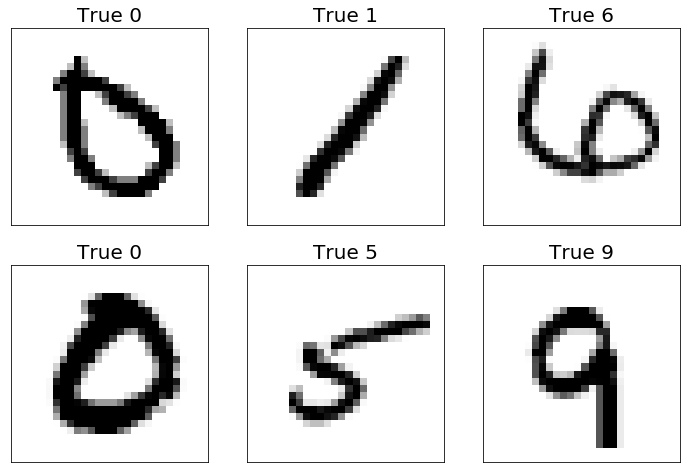

In [264]:
# look at a couple random digits from the training set
rand_inds = list(np.random.randint(0, high=len(X_train), size=6))
plot_input_images(X_train, np.array([np.argmax(y) for y in y_train]), rand_inds)

Above are some examples of the handwritten digits.  For each, we have 28x28 pixels with one color channel (greyscale).  I separated the data into training, validation and test sets - taking a portion of the samples from the training set for the validation set to use for model architecture selection and parameter tuning.  The samples in the test set will be held out for final model evaluation.

As this is just an exploratory project, I wanted to manually explore the model architecture space rather than use any sort of automated search.  I monitored the accuracy on my validation set while making changes.

In [235]:
# model architecture
DENSE_LAYERS = 1
DENSE_NODES = 256  # generally keep between input and output sizes
ACTIVATION = 'relu'
CONV_LAYERS = 2
FILTERS = 16
PATCHES = 3

img_dim = X_train.shape[-1]

In [248]:
inputs = layers.Input(shape=(1, img_dim, img_dim), name='inputs')

# convolutional layers with max pooling after each
for lay_i in range(CONV_LAYERS):
    layer_in = inputs if lay_i == 0 else x
    x = layers.Conv2D(FILTERS, (PATCHES, PATCHES), activation=ACTIVATION,
                      data_format='channels_first', name='conv{}'.format(lay_i))(layer_in)
    x = layers.MaxPooling2D(pool_size=(2, 2), name='pool{}'.format(lay_i))(x)

# dropout if there was a convolutional layer before flatten for dense input
if CONV_LAYERS > 0:
    x = layers.Dropout(0.2, name='conv_dropout')(x)
    x = layers.Flatten(name='flatten')(x)
else:
    x = layers.Flatten(name='flatten')(inputs)

# dense layers with dropout after each
for lay_i in range(DENSE_LAYERS):
    dense = int(DENSE_NODES/(lay_i+1))
    x = layers.Dense(dense, activation=ACTIVATION, name='dense{}'.format(lay_i))(x)
    x = layers.Dropout(0.25, name='dense_dropout{}'.format(lay_i))(x)

output = layers.Dense(10, activation='softmax', name='output')(x)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

I used Keras' functional API for this neural network because it provides a straightforward way to build up a model in a dynamic way.  First, let's take a look at the model I landed on.

In [237]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 1, 28, 28)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 16, 26, 26)        160       
_________________________________________________________________
pool0 (MaxPooling2D)         (None, 16, 13, 13)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 11, 11)        2320      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 16, 5, 5)          0         
_________________________________________________________________
conv_dropout (Dropout)       (None, 16, 5, 5)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
__________

There's a total of 10 layers, summarized below:
1. Input image
2. First convolutional layer, detects low level shapes
3. Max pooling layer down samples and provides invariance to translation, rotation and scale
4. Second convolutional layer, detects higher level features
5. Max pooling layer down samples and provides invariance to translation, rotation and scale
6. Dropout layer mitigates overfitting
7. Flatten layer gets the data in the right shape for dense layers
8. Dense layer
9. Dropout layer mitigates overfitting
10. Output layer with softmax activation acts as a classifier

Deciding on a model structure and tuning the parameters is an iterative process.  I set up an early stopping callback for both the training and validation data, so that if the accuracy of either one stalled it would stop the fit.  I also defined a simple step style learning rate scheduler that cuts the learning rate in half every couple epochs.  This helps the optimizer continue to improve the model's accuracy as the fitting process wears on.  I recorded the training and validation data losses and accuracy along with the learning rate every epoch, and at the end of the fit I plotted a simple visualization to see how training went.

The main thing I was looking for after fitting the model is how well the validation set accuracy tracked the training set accuracy.  If the training accuracy is well above the validation accuracy, then we know we're likely overfitting.

In [249]:
early_stop_train = EarlyStopping(monitor='acc', min_delta=0.001, patience=3,
                                 verbose=0, mode='auto')
early_stop_test = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=3,
                                verbose=0, mode='auto')
lr_scheduler = LearningRateScheduler(lr_function)
metrics = recordMetrics()

EPOCHS = 20
history = model.fit(X_train, y_train, epochs=EPOCHS, verbose=1,
                    callbacks=[metrics, early_stop_train, early_stop_test, lr_scheduler],
                    validation_data=(X_val, y_val))

Train on 52500 samples, validate on 7500 samples
Epoch 1/20
52500/52500 [==============================] - 55s 1ms/step - loss: 0.2220 - acc: 0.9319 - val_loss: 0.0596 - val_acc: 0.9827
Epoch 2/20
52500/52500 [==============================] - 49s 942us/step - loss: 0.0824 - acc: 0.9744 - val_loss: 0.0523 - val_acc: 0.9852
Epoch 3/20
52500/52500 [==============================] - 52s 984us/step - loss: 0.0620 - acc: 0.9804 - val_loss: 0.0418 - val_acc: 0.9883
Epoch 4/20
52500/52500 [==============================] - 50s 946us/step - loss: 0.0520 - acc: 0.9837 - val_loss: 0.0372 - val_acc: 0.9900
Epoch 5/20
52500/52500 [==============================] - 48s 910us/step - loss: 0.0368 - acc: 0.9886 - val_loss: 0.0337 - val_acc: 0.9896
Epoch 6/20
52500/52500 [==============================] - 48s 906us/step - loss: 0.0322 - acc: 0.9899 - val_loss: 0.0326 - val_acc: 0.9909
Epoch 7/20
52500/52500 [==============================] - 48s 915us/step - loss: 0.0291 - acc: 0.9909 - val_loss: 0.032

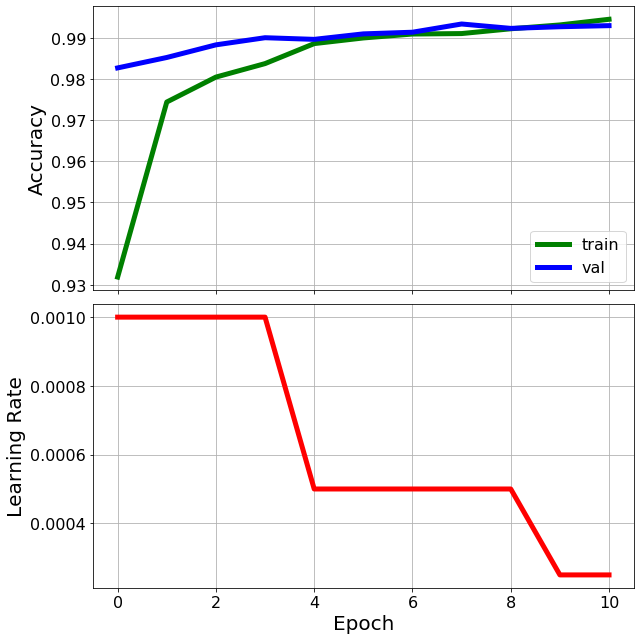

In [251]:
visualize_fit(metrics)

As you can see, it only took a couple epochs to get above 99% accuracy on both the training and validation sets.  By lowering the learning rate every so often, we're helping the model get incrementally better without bouncing around.  Importantly, the validation accuracy tracked with the training accuracy.  I'm happy with the final model here - 99.33% accuracy on the held out test set isn't too shabby.

Let's take a closer look at the model's performance.

In [252]:
y_pred = model.predict(X_test)
y_pred_max = np.array([np.argmax(pred) for pred in y_pred])
scores = model.evaluate(x=X_test, y=y_test)
print('Accuracy = {:.2%}'.format(scores[1]))

10000/10000 [==============================] - 3s 333us/step
Accuracy = 99.33%


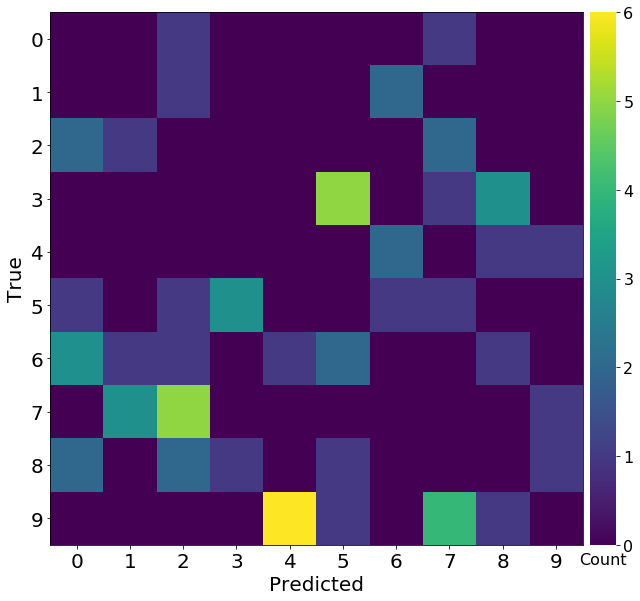

In [288]:
heat = classification_heat_map(y_test_raw, y_pred_max)
miss_heat = heat.copy()
np.fill_diagonal(miss_heat, val=0)
plot_heat(miss_heat)

The y-axis of the heat map is the true digit and the x-axis is the predicted digit, with the color of the square corresponding to the number of samples for that pairing.  Clearly, there were quite a few instances where we thought `9`s were `4`s, `7`s were `2`s,  and `3`s were `5`s.  These mixups are not unexpected, so that's a good sign the model isn't confusing numbers with significantly different shapes.

Let's look at the digits we predicted incorrectly **and** had a high confidence about.

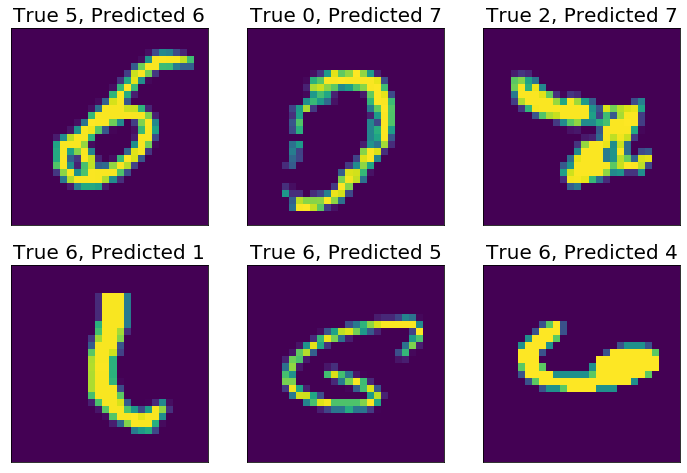

In [266]:
worst_inds = get_worst_predictions(y_test_raw, y_pred, num=6)
plot_input_images(X_test, y_test_raw, list(worst_inds), y_pred_max, cmap='viridis')

I mean.. some of these are pretty poorly written digits.  Others, like the lower row, middle column `6` does not look like a `5` like was predicted (even though it's a better `G` than a `6`).  Depending on the application, missing digits like these may or may not be acceptable.

Time to take a closer look at what the model is doing.

In [262]:
test_ind = 0

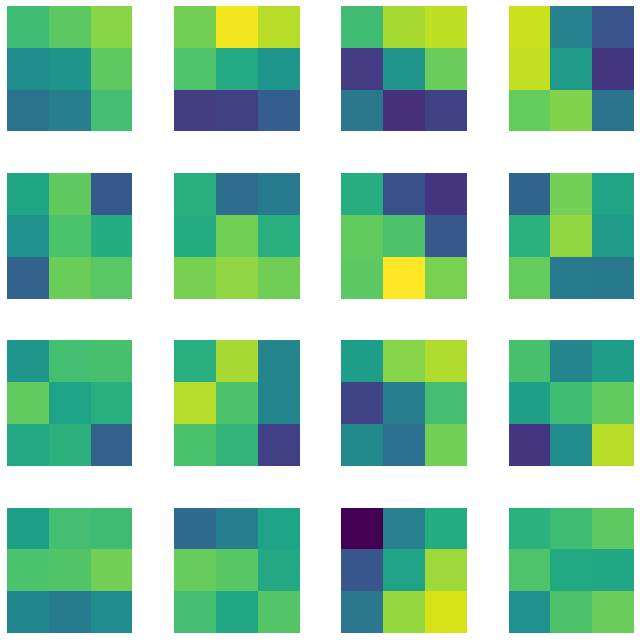

In [284]:
layer_info = {layer.name: layer for layer in model.layers}
layer = layer_info['conv0']
layer_weights = layer.get_weights()
filter_weights = np.array([np.squeeze(layer_weights[0][..., i]) for i in range(FILTERS)])

mosaic_dim = int(np.ceil(np.sqrt(filter_weights.shape[0])))
weights_mosaic = make_mosaic(filter_weights, mosaic_dim, mosaic_dim)
plot_weights(weights_mosaic)

These are the weights of the filters for the first convolutional layer (I left out the axes and colorbar because only the relative values matter for right now).  See [this great article](http://colah.github.io/posts/2014-07-Understanding-Convolutions/) for an explanation of convolutions, but in simple terms, imagine each of these filters sliding over each spot on the image.  Where the filter and the image match up well, the output of the layer will "light up."  Technically, "light up" is a garbage way to describe it, but you'll see why I said that coming up.  Next, we'll show a selected digit (the input to our model) and then the output of our convolutional layer.

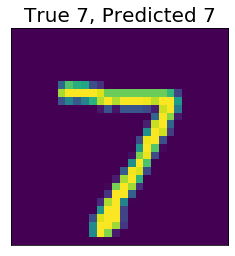

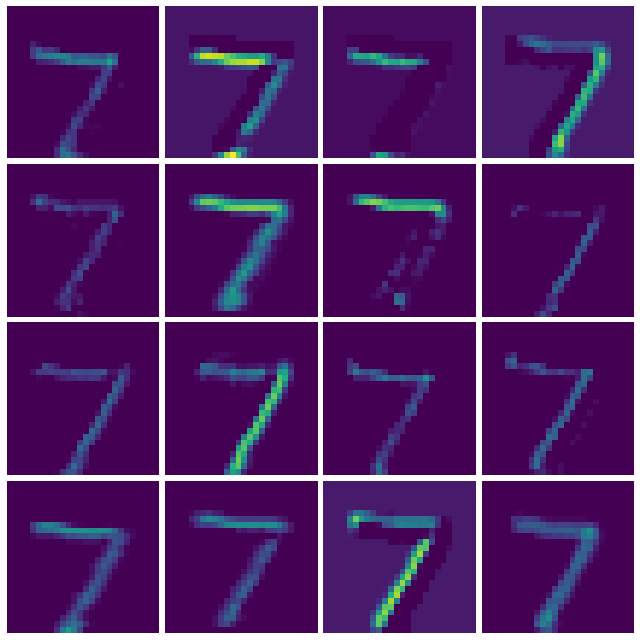

In [292]:
# show test image and conv filter ouputs
plot_input_images(X_test, y_test_raw, [test_ind], y_pred_max, cmap='viridis')
plot_layer_outputs(model, layer, X_test, test_ind)

The filters activate the input image in different ways.  Although each input image will activate the filters differently, *similar inputs will activate the same filters in similar locations*.  Although I am aware of the flaws of max pooling[^1], it is, for better or worse, effective for making the neural network invariant to image translation, scaling and orientation.

The techniques used for this problem can be applied to a range of image recognition tasks.  Experimenting with model architectures is often necessary to get good results, but there are a variety of resources out there to suggest architectures that are well suited to certain problem types.

[^1]: Geoffrey Hinton argues "The pooling operation used in convolutional neural networks is a big mistake and the fact that it works so well is a disaster."